In [16]:
from scipy.interpolate import interp1d
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.insert(1, '../ProcessEvents')
from ProcessEventsFunctions import *

def plot_incremental_rainfall(rainfall_array, ax, titles=True, labels=False):
    
    # Define custom labels for the bars
    bar_labels = ['F2', 'F1', 'C', 'B1', 'B2']

    # Define the color mapping
    color_mapping = {
        'F2': (0.0, 0.0, 1.0, 0.6),'F1': (0.0, 0.6902, 1.0, 0.6),'C': (0.5, 0.5, 0.5, 0.6),'B1': (0.8039, 0.0, 0.0, 0.6),   
        'B2': (0.5451, 0.0, 0.0, 0.6) }

    # Find the index of the maximum value
    index_of_max = np.argmax(rainfall_array)

    # Initialize all bars with a default color (e.g., white or light gray)
    colors = ['white'] * len(rainfall_array)  # Default color for all bars

    # Apply the color from the color_mapping to the bar at index_of_max
    colors[index_of_max] = color_mapping[bar_labels[index_of_max]]

    # Create the bar chart
    time_steps = np.arange(1, len(rainfall_array) + 1)
    ax.bar(time_steps, rainfall_array, label='Incremental Rainfall', color=colors, edgecolor='black')

    # Set custom labels on the x-axis
    ax.set_xticks(time_steps, bar_labels)
    
    ax.set_ylabel('Proportion of total rainfall', fontsize=12)
    if titles == True:
        ax.set_title('Rainfall accumulations (5 bins)', fontsize=15)
    if labels:
        ax.set_xlabel('Quintile class', fontsize=15)
    ax.grid('off');
    
def make_roberto_plot(sample, axs, titles=True, labels=True):
    
    cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(sample)
    dimensionless_cumulative_rainfall, dimensionless_times = create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
    interpolated_n_cumulative_rainfall, interpolated_n_times = interpolate_rainfall(dimensionless_cumulative_rainfall, n)
    interpolated_n_incremental_rainfall = create_incremental_event(interpolated_n_cumulative_rainfall)
    max_quintile_profile = find_part_with_most_rain(interpolated_n_incremental_rainfall, n)
    x_ticks = np.array(range(1, len(sample) + 1)) * 0.5  # [0.5, 1.0, 1.5]
    
    # 1. Raw Data Plot
    axs[0].bar(np.array(range(1, len(sample) + 1)) * 0.5, sample, color='royalblue', alpha=0.7, width=0.4)

    axs[0].set_ylabel('Rainfall (mm)', fontsize=15)
    # axs[0].set_xticks(x_ticks)
    
    # 2. Dimensionless Cumulative Values
    time_percentage = (np.arange(0, len(sample) + 1) / len(sample)) * 100  
        
    axs[1].plot(time_percentage, dimensionless_cumulative_rainfall, 
                label='Cumulative Sum', linewidth=2, marker='o', color='royalblue', markerfacecolor='purple')

    # Plot horizontal line for the corresponding sample value
    percentile = 0.5
    total_duration = len(sample) * 0.5  # 1.5 hours
    axs[1].axhline(y=percentile, color='black', linestyle='--', label=f'{percentile}th Percentile')
    axs[2].set_ylabel('Proportion of total rainfall', fontsize=12)
    # Find intersection point for percentile line
    indices_below = np.where(dimensionless_cumulative_rainfall < percentile)[0]
    indices_above = np.where(dimensionless_cumulative_rainfall >= percentile)[0]
    
    if len(indices_below) > 0 and len(indices_above) > 0:
        index_below = indices_below[-1]
        index_above = indices_above[0]
        
        # Interpolation to find intersection
        x_below = time_percentage[index_below]
        y_below = dimensionless_cumulative_rainfall[index_below]
        x_above = time_percentage[index_above]
        y_above = dimensionless_cumulative_rainfall[index_above]
        slope = (y_above - y_below) / (x_above - x_below)
        time_for_percentile = x_below + (percentile - y_below) / slope
        
        axs[1].axvline(x=time_for_percentile, color='red', linestyle='-', linewidth=3)
        axs[1].annotate(f'D50: {time_for_percentile:.1f}%', 
                        xy=(time_for_percentile, percentile), 
                        xytext=(time_for_percentile, percentile  - 0.4),  
                        arrowprops=dict(facecolor='black', arrowstyle='->'),   
                        fontsize=16)

    # 3. Interpolated Cumulative Values
    interpolated_n_times_percentage = interpolated_n_times * 100 
    axs[2].plot(interpolated_n_times_percentage, interpolated_n_cumulative_rainfall, label='Cumulative Sum',linewidth=2,  marker='o', 
                color='royalblue', markersize=8, markerfacecolor='magenta')

    axs[2].set_ylabel('Proportion of total rainfall', fontsize=12)
    axs[2].set_xlim(0, 100)

    # Call the function for the last subplot
    plot_incremental_rainfall(interpolated_n_incremental_rainfall, axs[3], titles, labels)

    for ax in axs:
        ax.tick_params(axis='both', labelsize=14)  # Adjust labelsize as needed
     
    axs[1].set_ylabel('Proportion of total rainfall', fontsize=12)
    axs[2].set_ylabel('Proportion of total rainfall', fontsize=12)
    
    if labels == True:
        axs[0].set_xlabel('Time (hours)', fontsize=15) 
        axs[1].set_xlabel('Proportion of duration', fontsize=15)  
        axs[2].set_xlabel('Proportion of duration', fontsize=15)    
        
        
    if titles:
        axs[0].set_title('Raw rainfall (mm)', fontsize=15)        
        axs[2].set_title('Dimensionless cumulative rainfall \n interpolated to len 5', fontsize=15)        
        axs[1].set_title('Dimensionless cumulative rainfall, \n with linearly interpolated lines', fontsize=15)  

## Get some sample data

In [10]:
n=5

In [11]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [12]:
time_period='Future'
gauge_num=1
em = 'bb189'
indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/"

files = [f for f in os.listdir(indy_events_fp) if f.endswith('.csv')]
files = np.sort(files)

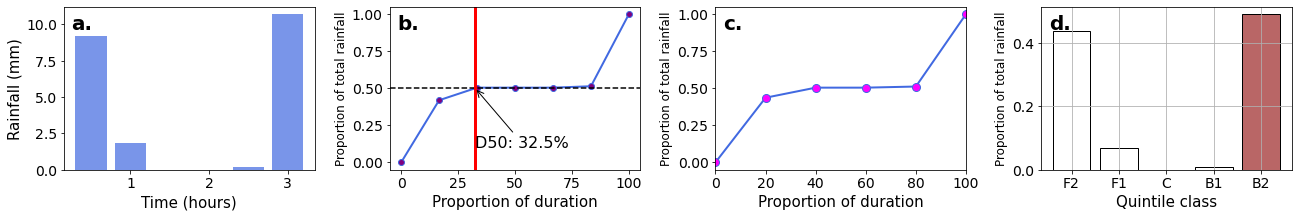

In [21]:
sample1 = pd.read_csv(indy_events_fp + files[5])['precipitation (mm)']
sample2 = pd.read_csv(indy_events_fp + files[1])['precipitation (mm)']
sample3 = pd.read_csv(indy_events_fp + files[29])['precipitation (mm)']

fig, axs = plt.subplots(1, 4, figsize=(22, 3))  
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
make_roberto_plot(sample1, axs, titles=False, labels = True)  # Third row for sample3
labels = ['a.', 'b.', 'c.', 'd.']
for ax, label in zip(axs.flat, labels):
    ax.text(0.03, 0.95, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
fig.savefig("../AnalyseProfiles/Figs/methods_event1.png", dpi=500, bbox_inches='tight')     